<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Torch源代码基础链路" data-toc-modified-id="Torch源代码基础链路-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Torch源代码基础链路</a></span><ul class="toc-item"><li><span><a href="#源代码结构" data-toc-modified-id="源代码结构-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>源代码结构</a></span></li><li><span><a href="#实现链路：以Tensor.dtype为例" data-toc-modified-id="实现链路：以Tensor.dtype为例-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>实现链路：以Tensor.dtype为例</a></span></li><li><span><a href="#实现链路：以torch.add为例" data-toc-modified-id="实现链路：以torch.add为例-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>实现链路：以torch.add为例</a></span></li></ul></li></ul></div>

In [1]:
import torch

> 使用的是torch 1.13.1版本

# Torch源代码基础链路

pytorch的底层实现其实是基于C/C++的，平常我们大多使用其提供的python接口编写模型训练和推理代码（pip安装torch包），或者有时候直接使用其C++接口（libtorch.so）。torch中的Tensor、device、自动求导等功能都在底层实现。

## 源代码结构

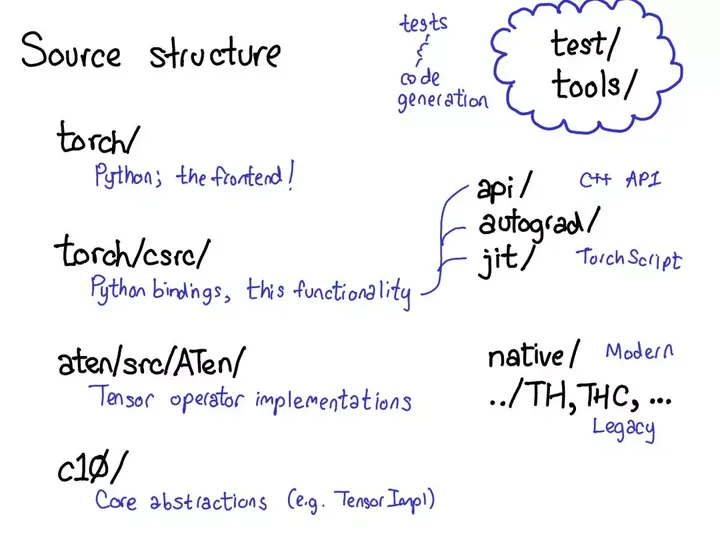

根据[torch的官方说明](https://github.com/pytorch/pytorch/blob/v1.13.1/CONTRIBUTING.md#codebase-structure)，源代码中比较重要的几个目录有：
+ torch: 我们平常使用的python接口和相关函数
+ torch/csrc: 使用pybind11绑定python接口和c++接口，而绑定的代码并不是手动一个一个写的，而是通过函数自动生成的，这里就需要结合tools目录下的脚本来实现:
  - jit：对应TorchScript，是pytorch提供的静态图实现方式
  - autograd: 自动求导相关功能，用于模型训练时loss的反向求导
  - api: C++提供的接口
  - distributed: 分布式训练
+ aten/src/ATen: A Tesor Library, C++实现的张量计算库，我们在torch前端用到的很多计算函数或者说算子，其实绝大部分在底层都是用aten实现的。
+ tools: 代码自动生成的相关脚本，包括生成pybind11绑定代码、*.pyi存根文件编译.so动态库和编译libtorch.so等
  - autograd: 
  - jit
  - setup_helpers
  - build_pytorch_libs.py
  - build_libtorch.py
+ test: 测试代码
+ caffe2: Caffe2工具库的相关代码
+ c10: torch完整的集成了caffe框架的后端，用于实现基本的Tensor操作，在ATen中会看到大量使用了C10中的功能。

## 实现链路：以Tensor.dtype为例

下面以Tensor.dtype为例来说明torch的整个实现链路。下面的代码随机初始化了一个Tensor变量a，并且打印了其类型，那么在这后面到底调用了哪些代码？

In [4]:
a = torch.Tensor()
a.dtype

torch.float32

首先，调用`torch.Tensor()`返回的a是`torch.Tensor`类型，那么先来看类`Tensor`的定义。根据python的机制，当我们调用`torch.Tensor()`时，其实是从`torch/__init__.py`中找`Tensor`。从下面的导入代码中可以看到`Tensor`的定义在`_tensor.py`文件中。

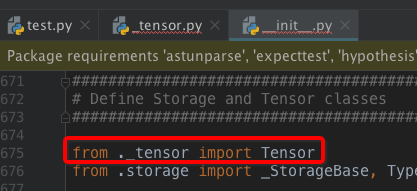
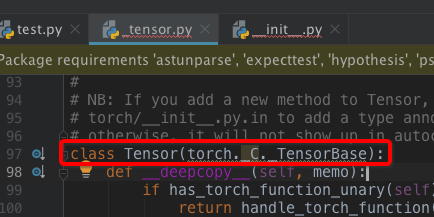

根据`Tensor`的定义可以发现它继承了类`torch._C._TensorBase`。那么现在遇到了torch中一个很重要`_C`模块。在解释这个模块之前，需要介绍一下pybind11。简单来说，当我们希望在python中调用使用C++编写的函数时，可以通过pybind11定义C++对应的python模块和函数，从而在python实现import模块并调用相应函数。同样的，torch中python接口和C++接口的绑定也是由pybind11完成，而`_C`就是C++动态库对应的python模块名称。此外，还初始化了其他接口，如jit, torch.nn等。

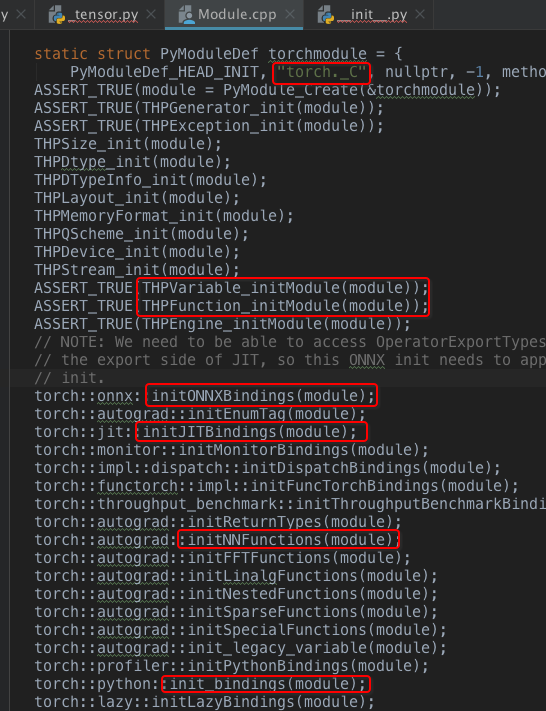

那么显然，类`torch._C._TensorBase`接口必然对应了某个C++中的接口，我们可以在`_TensorBase`的定义文件中找到：
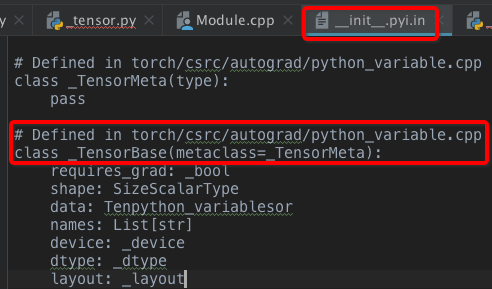

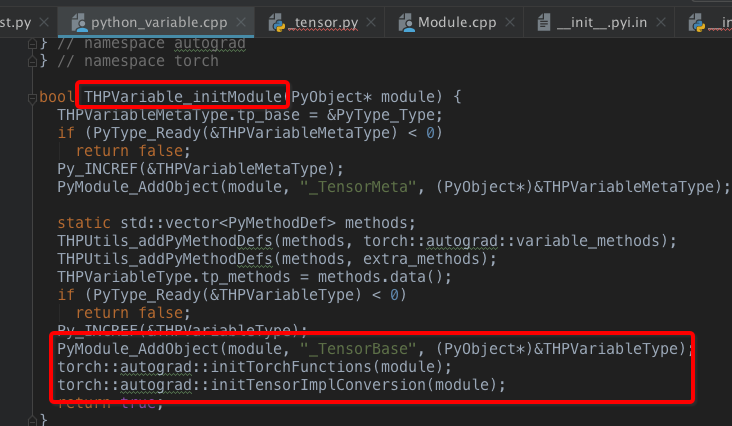

从pybind11的定义中得知`_TensorBase`对应了C++中的`THPVariableType`：
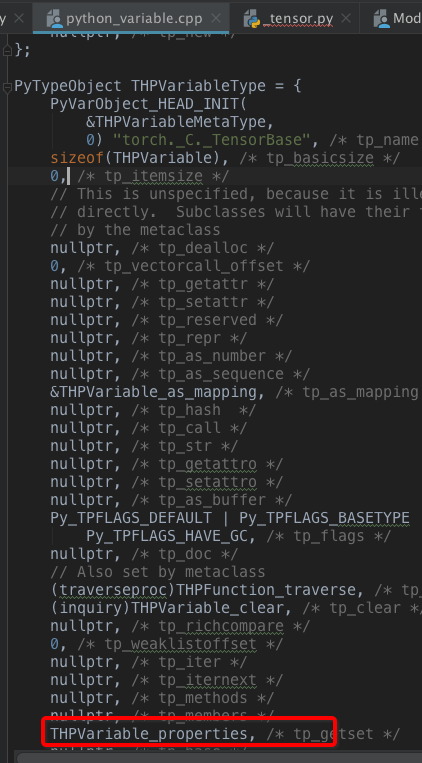

而从`THPVariableType`的定义中并没有找到dtype这个函数或者属性，其实它是定义在结构体`THPVariable_properties`中，这个结构体包含了Tensor的相关属性，比如dtype、ndims、shape等。

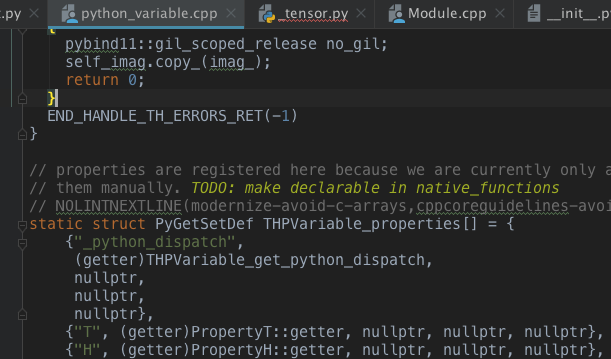
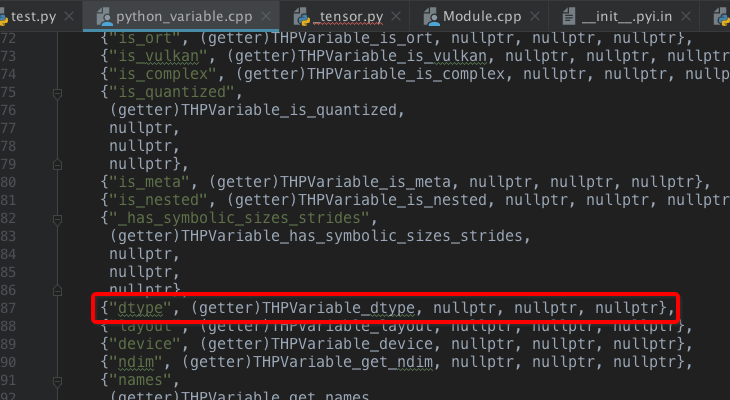

进一步从结构体的定义中可以发现dtype对应`THPVariable_dtype`函数，这个函数输入的`THPVariable`是调用dtype的对象，最终调用`torch::getTHPDtype(self_.scalar_type())`获取类型。

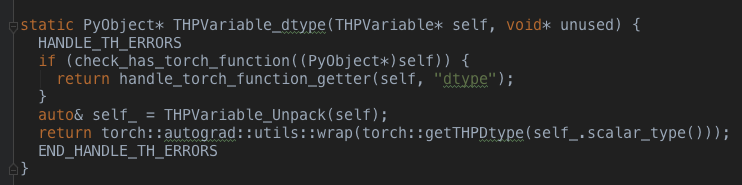

> 
> 这里稍微解释一下`check_has_torch_function`和`handle_torch_function_getter`在干嘛。平常当我们在使用a.dtype获取类型是，a可能是Tensor也可能是numpy::ndarray。如果是Tensor那么可以直接调用Tensor对应的函数，但是如果是ndarray要怎么办呢？torch就提供了一种类似“子类”的方式来支持，这个子类需要有`__torch__function__`属性来记录自己实现了什么对应的torch函数，从而可以使用handle_torch_function_getter获取对应的函数。
> + https://github.com/pytorch/pytorch/issues/22402
> + https://github.com/pytorch/pytorch/issues/24015

首先来看`scalar_type()`在干什么，这个函数获取的是`ScalarType`类型的结果。而`ScalarType`在C10中定义：
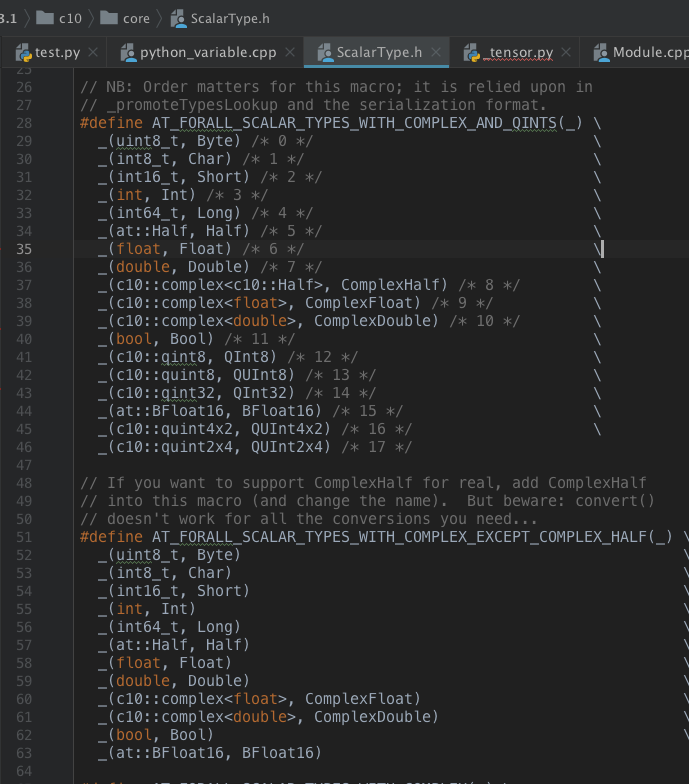

在初始化的时候会注册所有的类型，将类型转换为我们更熟悉的float32、float16等类型：
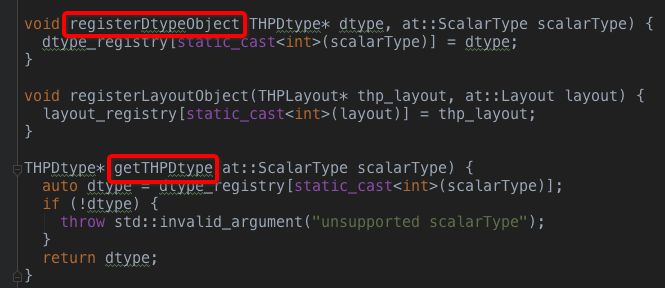

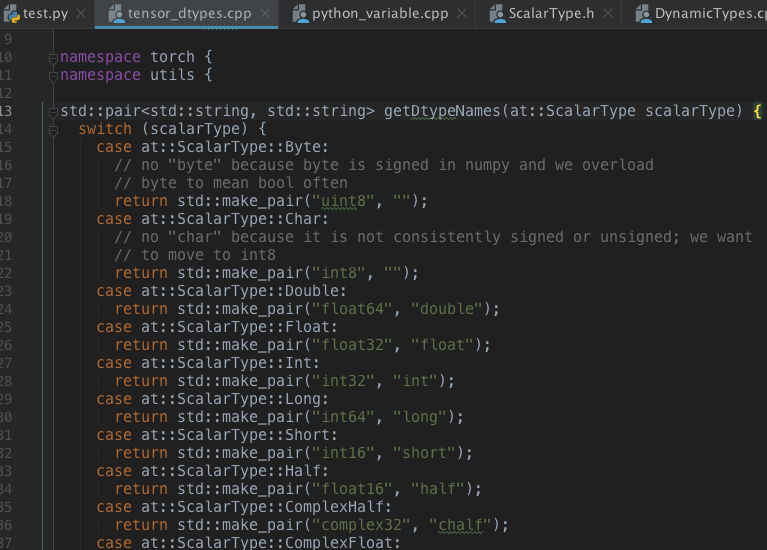



在调用.dtype时从注册map中获取结果：`THPDtype* getTHPDtype(at::ScalarType scalarType)`
